In [1]:

!apt updateapt update
!pip install mdbtools-dev
!apt-get install mdbtools
!pip install pandas pyodbc
!pip install pymssql
!pip install tempfile2
import warnings
warnings.filterwarnings('ignore')

E: Invalid operation updateapt
ERROR: Could not find a version that satisfies the requirement mdbtools-dev (from versions: none)
ERROR: No matching distribution found for mdbtools-dev
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
mdbtools is already the newest version (1.0.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Dev/py2/')
import numpy as np

import pandas as pd
from google.colab import files
import os
import subprocess
from io import StringIO  # StringIOを正しくインポート
import model.utility.k_analysis_util as k_a_util
from IPython.display import display

from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

import model.utility.k_analysis_util as k_analysis_util

In [4]:
#db_path = "/content/drive/MyDrive/Dev/Kjvan/kjdb_prediction_cache_2024.accdb"
db_path = "/content/drive/MyDrive/Dev/Kjvan/kjdb_score.accdb"


In [5]:

cmd = f"select * from BaseTime"
print(cmd)

select * from BaseTime


In [ ]:
df_re = k_analysis_util.execute_mdb_sql(db_path, cmd)

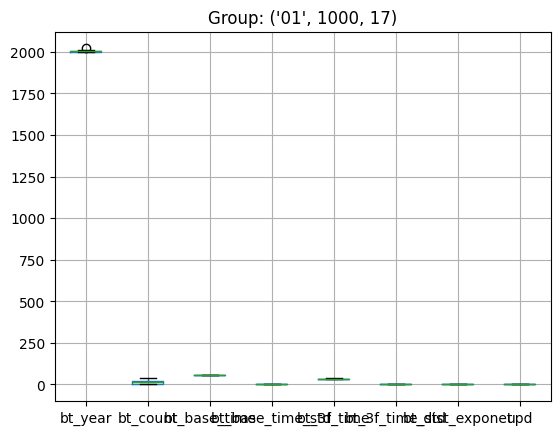

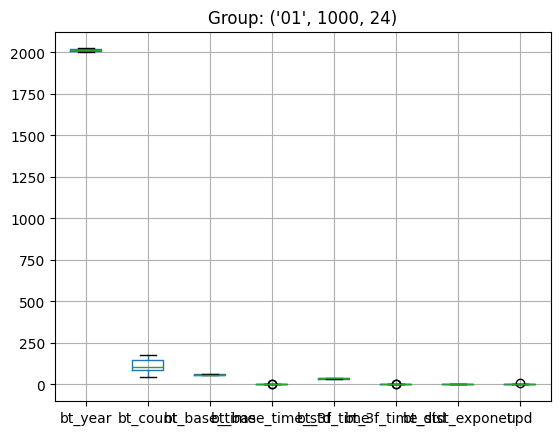

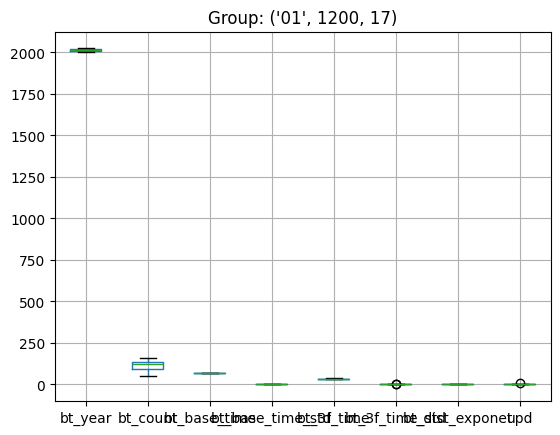

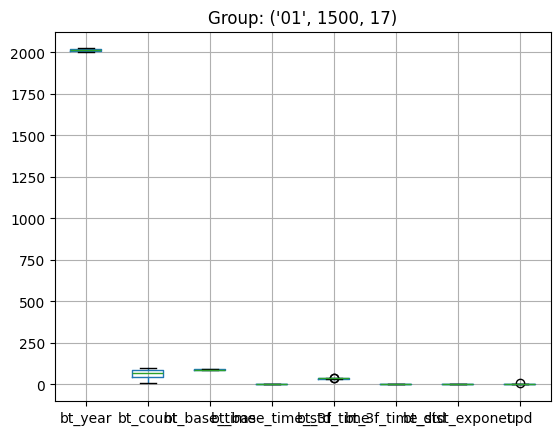

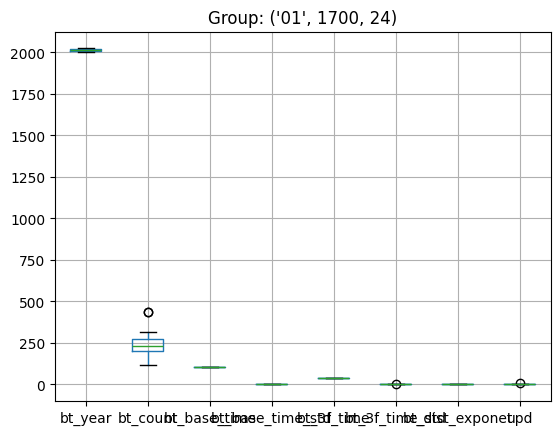

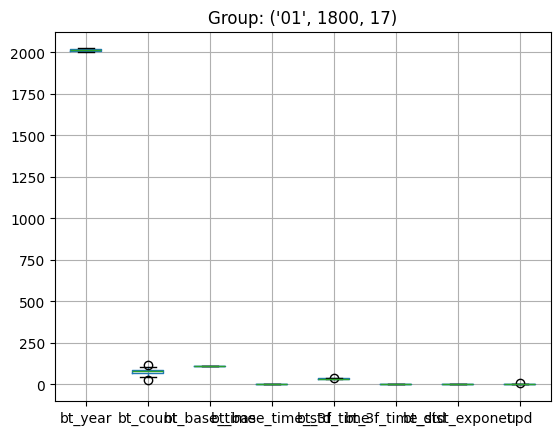

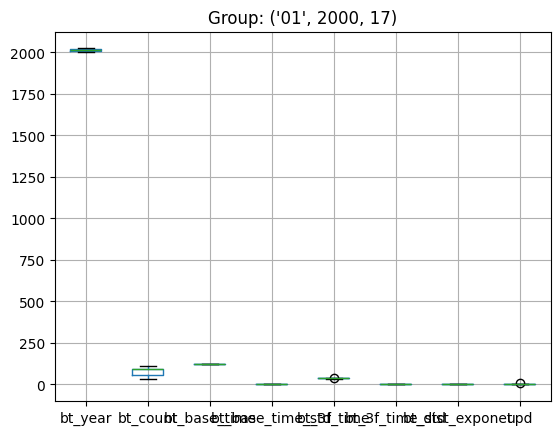

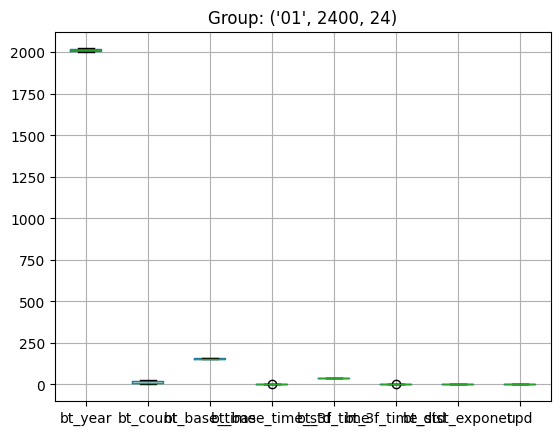

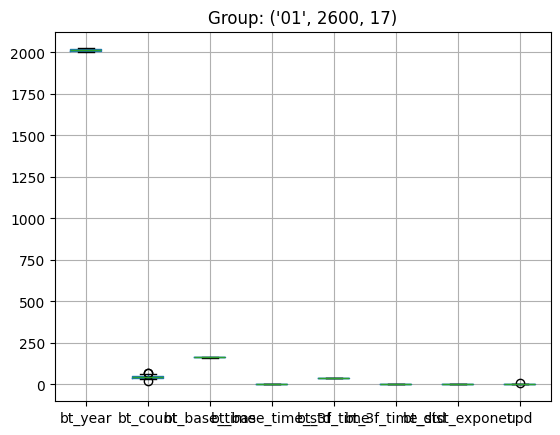

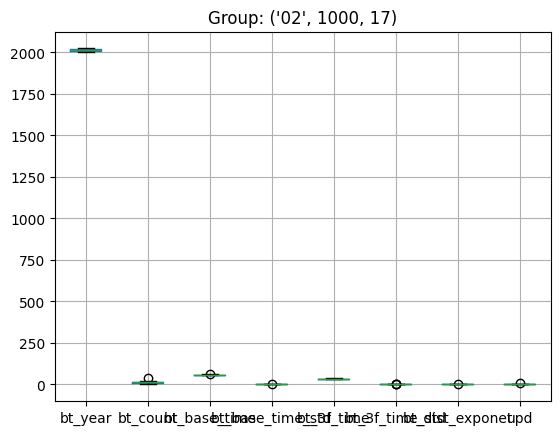

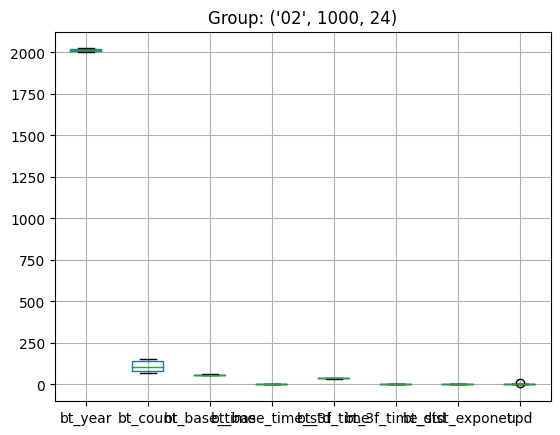

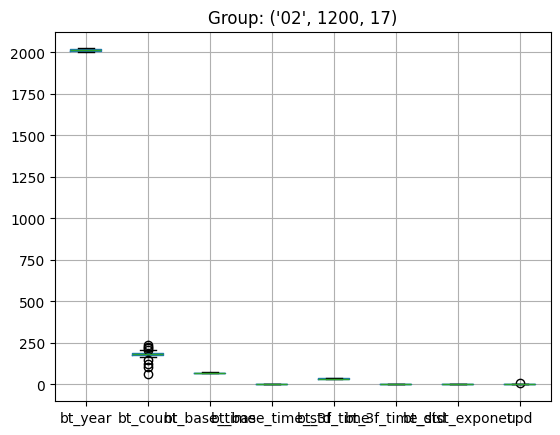

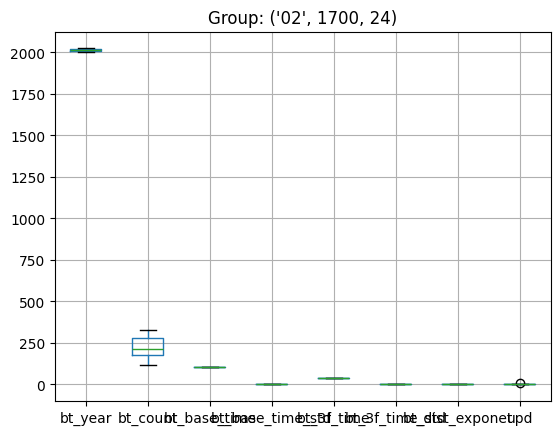

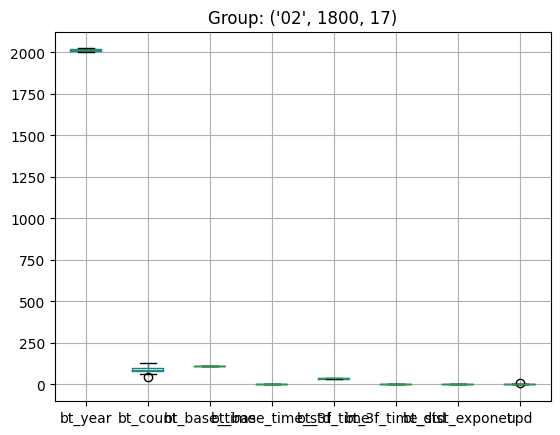

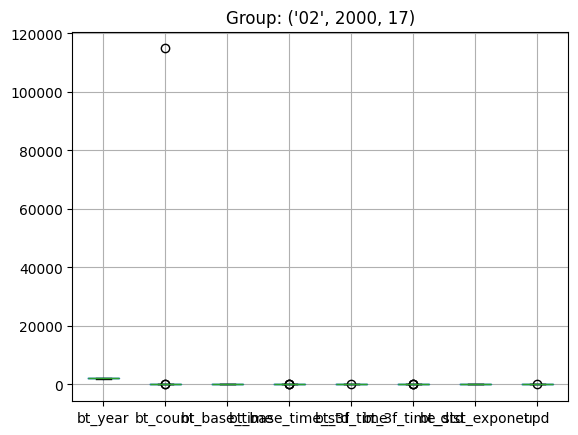

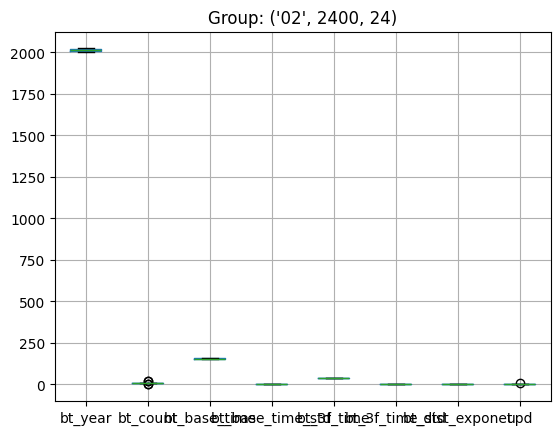

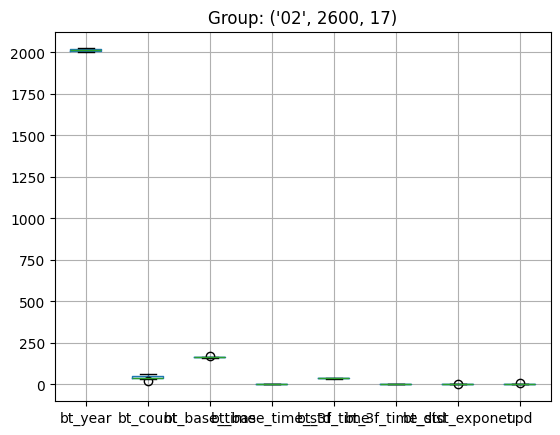

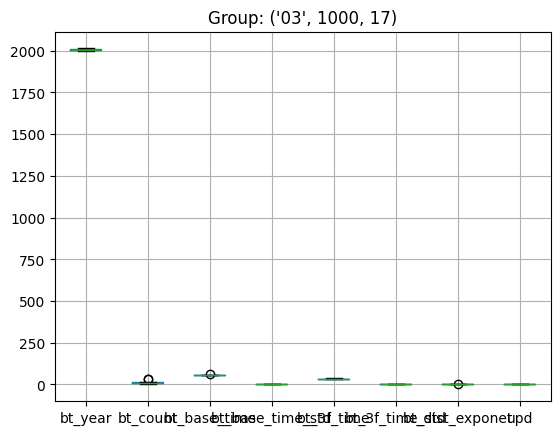

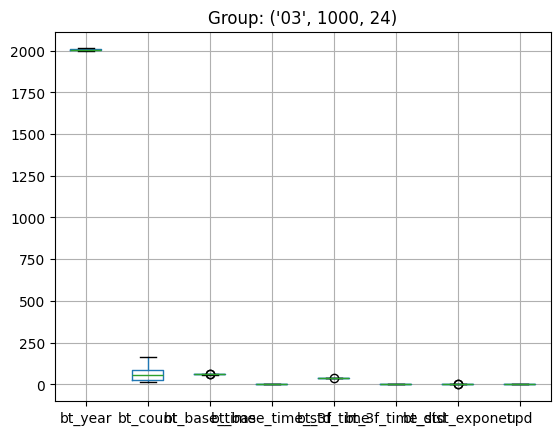

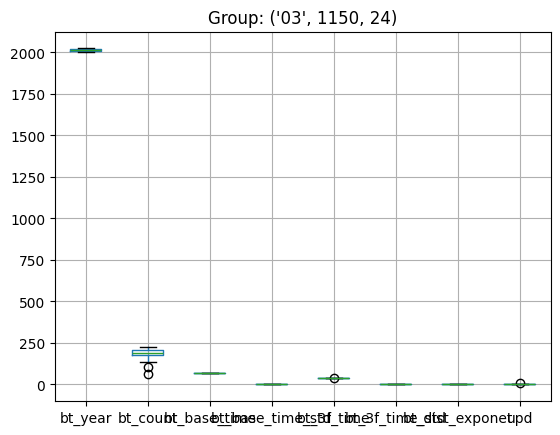

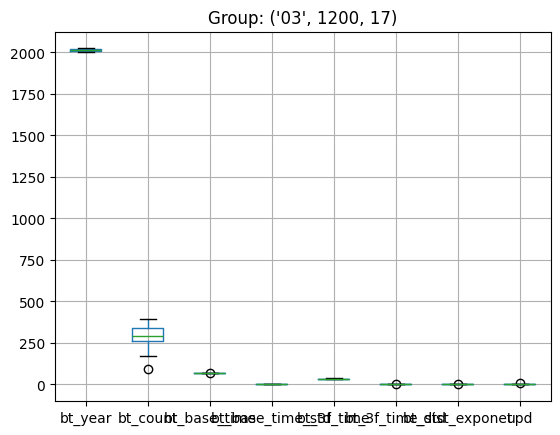

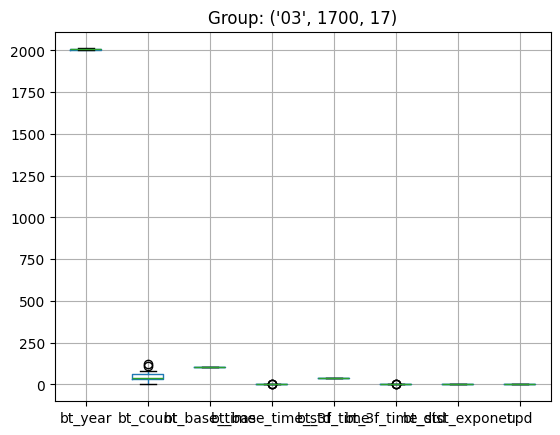

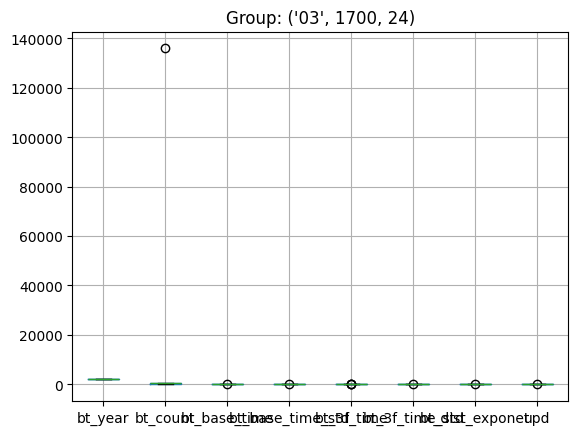

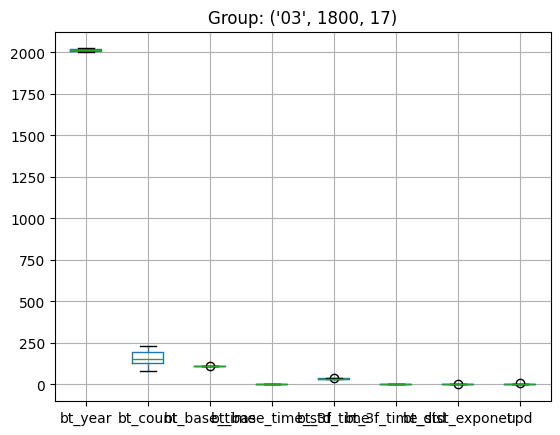

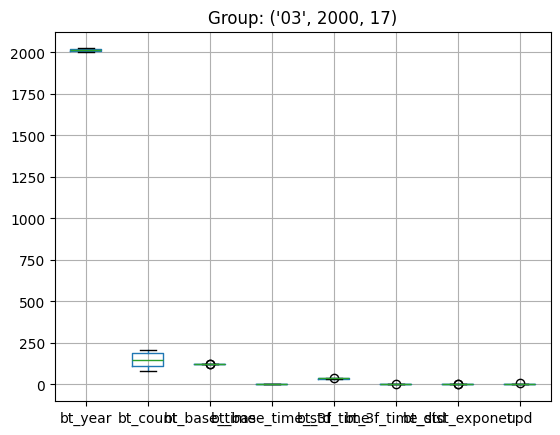

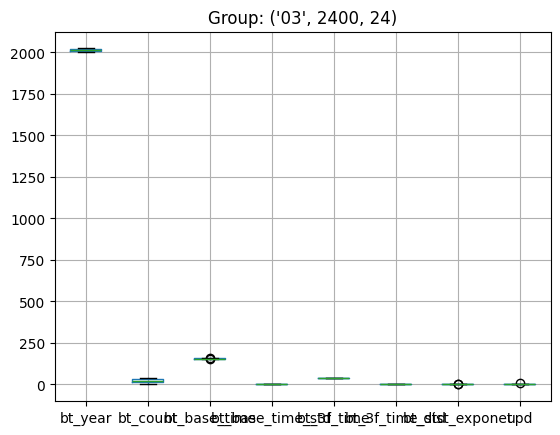

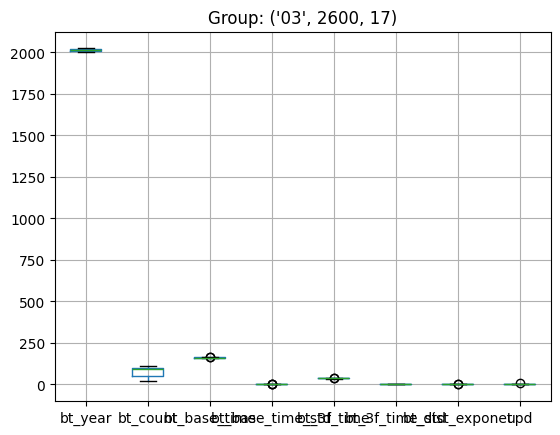

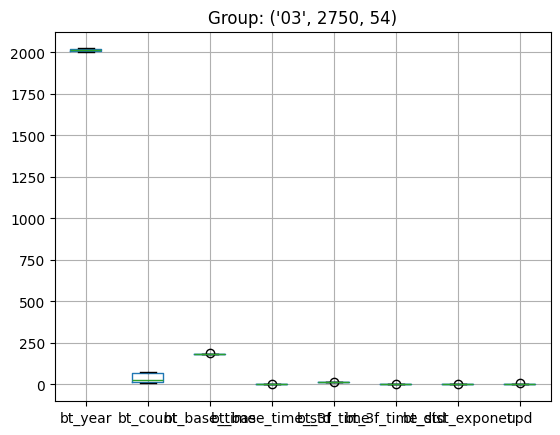

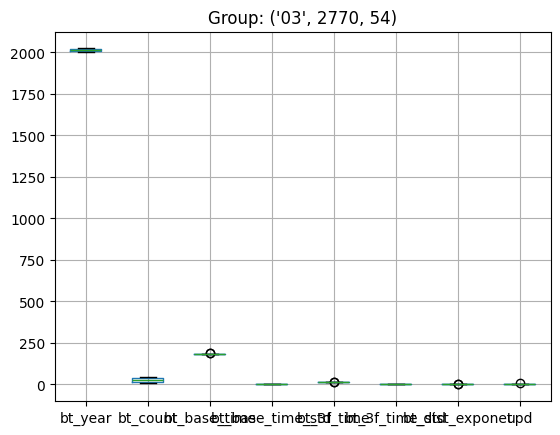

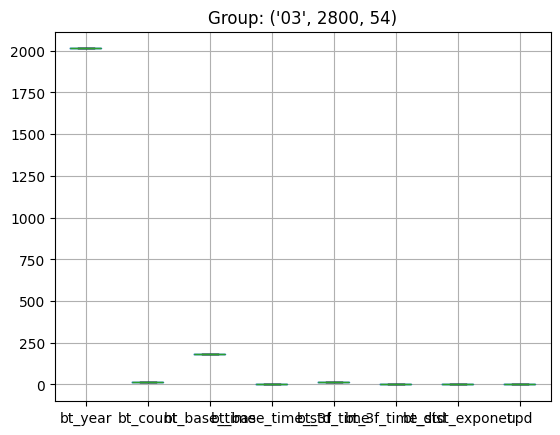

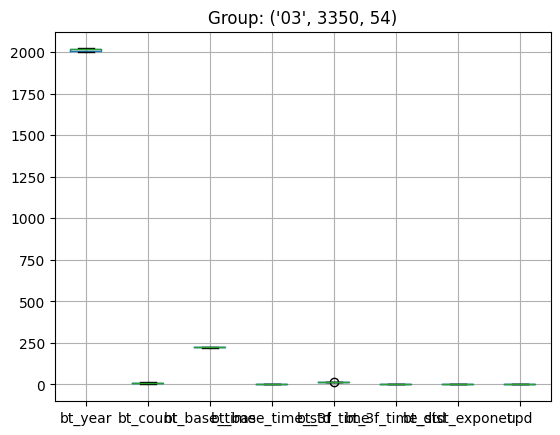

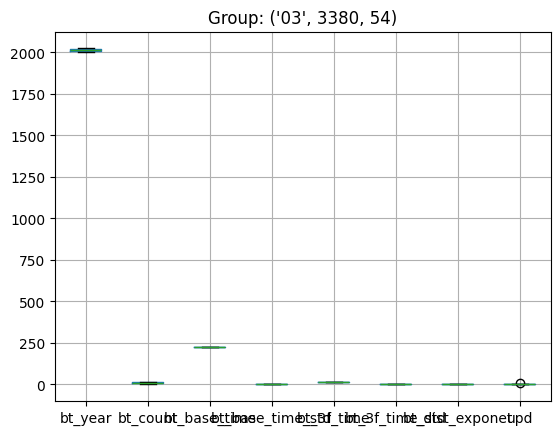

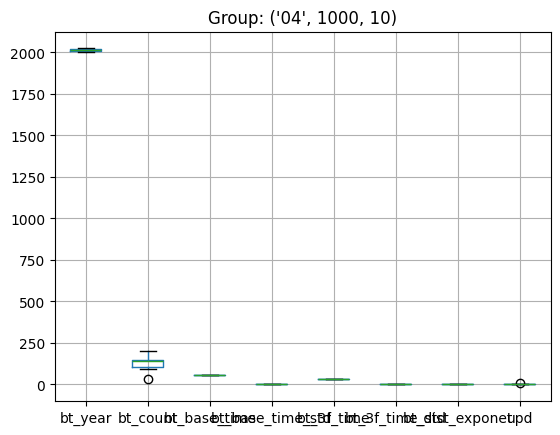

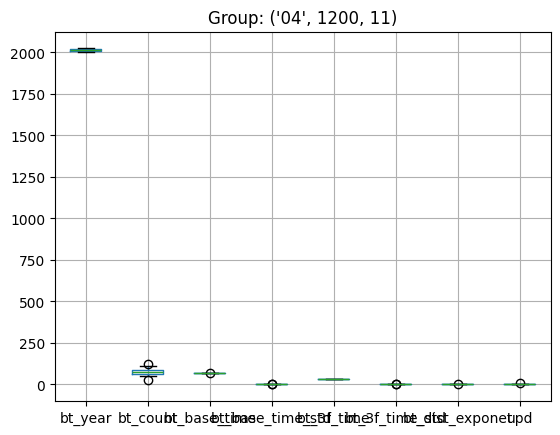

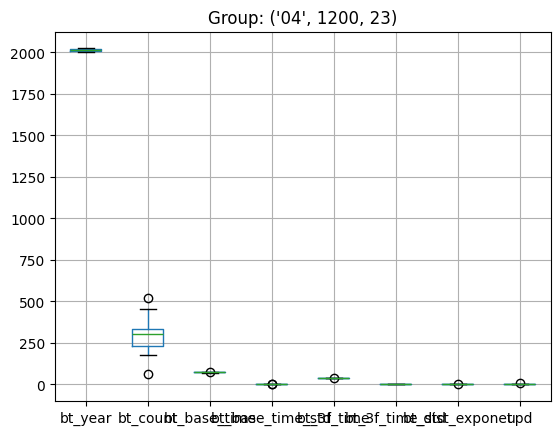

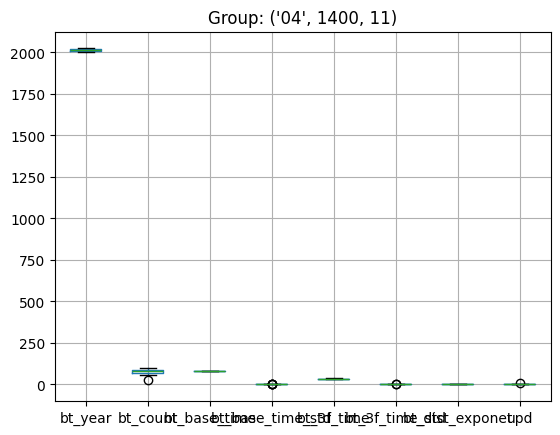

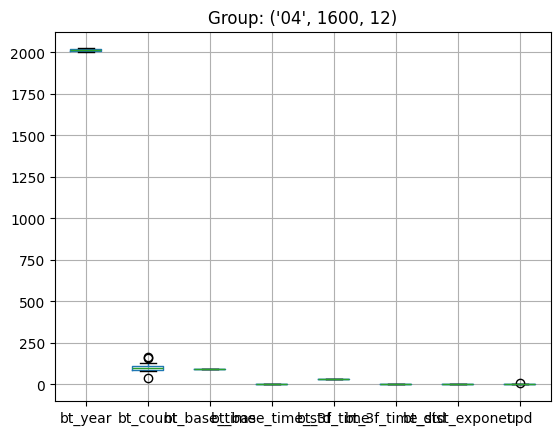

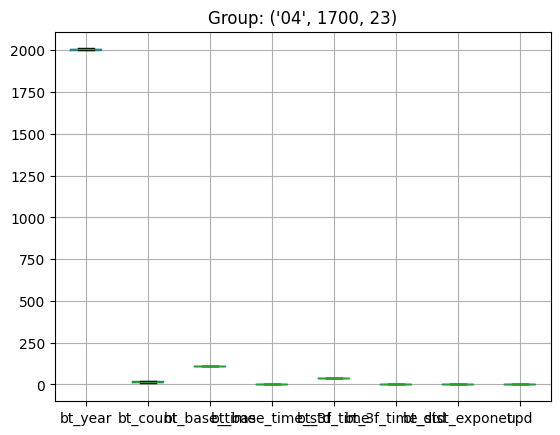

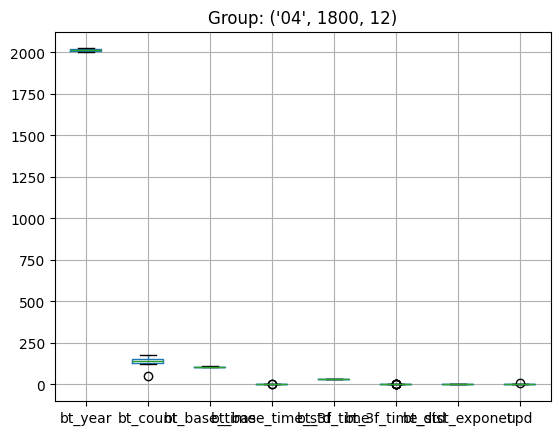

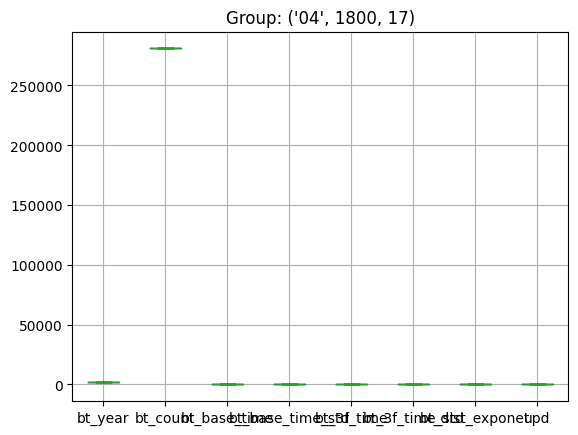

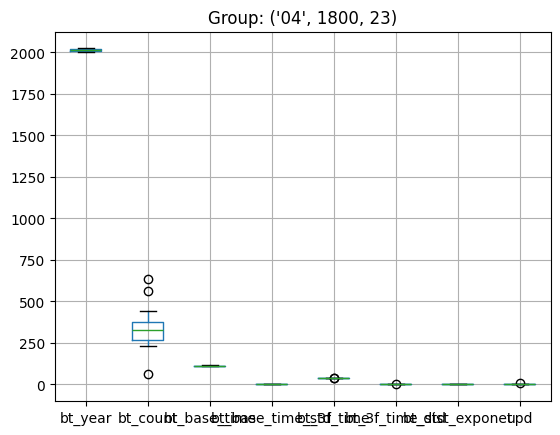

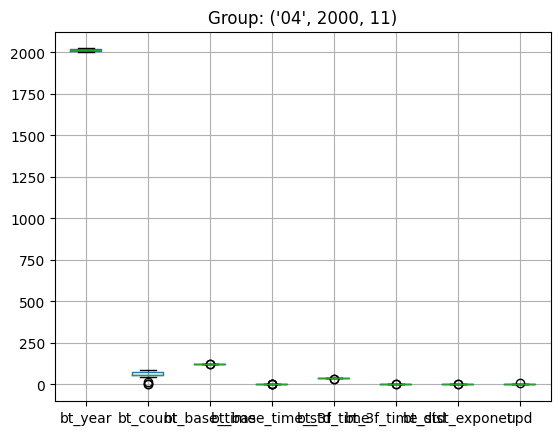

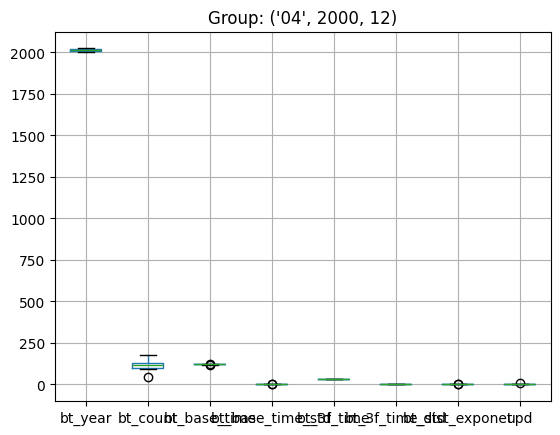

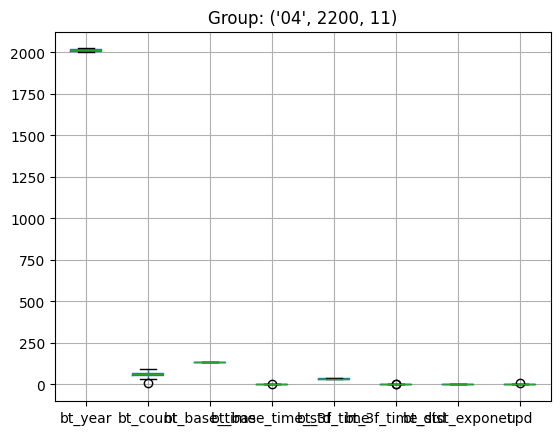

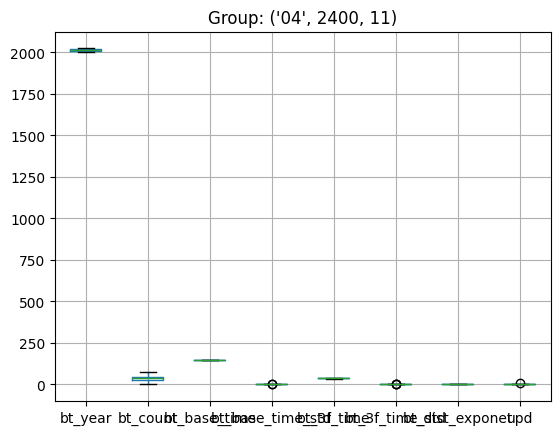

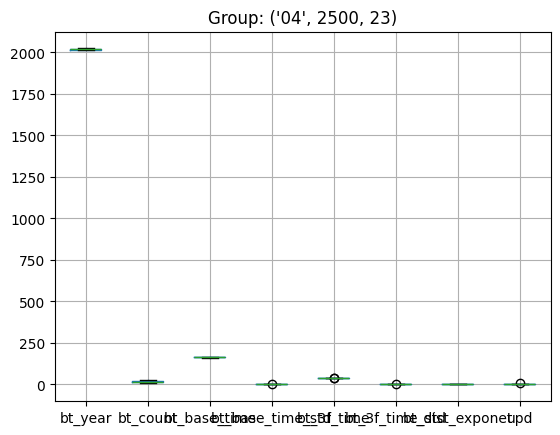

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# bt_place、bt_distance、bt_track_cdでグループ化
grouped = df_re.groupby(['bt_place', 'bt_distance', 'bt_track_cd'])

# 各グループごとに箱ひげ図を描画
for group_name, group_df in grouped:
    plt.figure()
    group_df.drop([ 'bt_place', 'bt_distance', 'bt_track_cd'], axis=1).boxplot()
    plt.title(f'Group: {group_name}')
    plt.show()


In [7]:
import subprocess

def list_mdb_tables(mdb_file_path: str):
    cmd = ['mdb-tables', mdb_file_path]
    process = subprocess.Popen(
        cmd,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )
    stdout, stderr = process.communicate()

    if process.returncode != 0:
        print(f"Error listing tables: {stderr}")
        return []

    tables = stdout.split()
    return tables

tables = list_mdb_tables(db_path)
print("Tables and Views:", tables)


Tables and Views: ['AverageTimeMaidenRace', 'BaseTime', 'BloodScore', 'JockeyScore', 'MSysCompactError', 'TrainerScore', 'StudScore']
